<a href="https://colab.research.google.com/github/sebastiano-saccani/generative_mixed_types/blob/master/tf_cvae_mixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Mixed COntinuous/Categorical Variational Autoencoder

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/beta/tutorials/generative/cvae">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/r2.0rc/site/en/r2/tutorials/generative/cvae.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/r2.0rc/site/en/r2/tutorials/generative/cvae.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/r2/tutorials/generative/cvae.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

<!-- ![evolution of output during training](https://tensorflow.org/images/autoencoders/cvae.gif) -->

This notebook demonstrates how to generate continuous datasets by training a Variational Autoencoder ([1](https://arxiv.org/abs/1312.6114), [2](https://arxiv.org/abs/1401.4082)).



## Import TensorFlow and other libraries

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

from IPython import display

# Uploading mixed continuous/categorical dataset
Preparing dataset

In [0]:
columns = ['age',
  'sex',
  'on thyroxine',
  'query on thyroxine',
  'on antithyroid medication',
  'sick',
  'pregnant',
  'thyroid surgery',
  'I131 treatment',
  'query hypothyroid',
  'query hyperthyroid',
  'lithium',
  'goitre',
  'tumor',
  'hypopituitary',
  'psych',
  'TSH measured',
  'TSH',
  'T3 measured',
  'T3',
  'TT4 measured',
  'TT4',
  'T4U measured',
  'T4U',
  'FTI measured',
  'FTI',
  'TBG measured',
  'TBG',
  'target',
  'target1'
]

In [0]:
import pandas as pd
data_in=pd.concat([pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/thyroid-disease/allbp.data',header=None,index_col=None),
                   pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/thyroid-disease/allhyper.data',header=None,index_col=None),
                   pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/thyroid-disease/allhypo.data',header=None,index_col=None),
                   pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/thyroid-disease/allrep.data',header=None,index_col=None)
                  ])
data_in.columns=columns
index = data_in['TSH measured'] != 'f'
index = np.logical_and(index,data_in['T3 measured'] != 'f')
index = np.logical_and(index,data_in['TT4 measured'] != 'f')
index = np.logical_and(index,data_in['T4U measured'] != 'f')
index = np.logical_and(index,data_in['FTI measured'] != 'f')
data_in = data_in[index]
#data_in = data_in[np.logical_not(np.asarray(data_in=='?').any(axis=1))]
del data_in['TBG'],data_in['target'],data_in['target1'],data_in['TSH measured'],data_in['T3 measured'],data_in['TT4 measured'],data_in['T4U measured'],data_in['FTI measured'],data_in['TBG measured']
data_in = data_in[np.logical_not(np.asarray(data_in=='?').any(axis=1))]
data_in = data_in[np.logical_not(np.asarray(data_in[['age']]=='F').any(axis=1))]
data_in = data_in.loc[['F' not in i for i in data_in['age']]]
data_in = data_in[np.logical_not(data_in.isna().any(axis=1))]

In [0]:
dtypes={
  'age':np.float64,
  'TSH':np.float64,
  'T3':np.float64,
  'TT4':np.float64,
  'T4U':np.float64,
  'FTI':np.float64,
  'sex':'category',
  'on thyroxine':'category',
  'query on thyroxine':'category',
  'on antithyroid medication':'category',
  'sick':'category',
  'pregnant':'category',
  'thyroid surgery':'category',
  'I131 treatment':'category',
  'query hypothyroid':'category',
  'query hyperthyroid':'category',
  'lithium':'category',
  'goitre':'category',
  'tumor':'category',
  'hypopituitary':'category',
  'psych':'category',

}
for key in dtypes.keys():
  data_in[key]=data_in[key].astype(dtypes[key])

### one hot encoding of categorical variables

In [0]:
data_in = data_in.sample(frac=1)
data_dummy = pd.get_dummies(data_in)  # One-hot-encoding

### scaling floating point variables

In [0]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer
data_dummy[['age','TSH','T3','TT4','T4U','FTI']] = QuantileTransformer(output_distribution='normal')\
.fit_transform(data_dummy[['age','TSH','T3','TT4','T4U','FTI']])

### list containing groups baounday and variables types

In [0]:
# defing group boundary indexes
split_list = [[6,'float'],
              [2,'cat'],
              [2,'cat'],
              [2,'cat'],
              [2,'cat'],
              [2,'cat'],
              [2,'cat'],
              [2,'cat'],
              [2,'cat'],
              [2,'cat'],
             ]

In [0]:
data_dim = np.sum([i[0] for i in split_list])

In [0]:
data_dummy = data_dummy.loc[:,data_dummy.columns[:data_dim]]
data_dummy=np.asarray(data_dummy)
train_data = data_dummy[:7000,:]
test_data  = data_dummy[7000:,:]
train_data = train_data.reshape(train_data.shape[0], train_data.shape[1]).astype('float32')
test_data = test_data.reshape(test_data.shape[0], test_data.shape[1]).astype('float32')

In [0]:

TRAIN_BUF = 500
BATCH_SIZE = 100
TEST_BUF = 500

## Use *tf.data* to create batches and shuffle the dataset

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_data).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_data).shuffle(TEST_BUF).batch(BATCH_SIZE)

## Wire up the generative and inference network with *tf.keras.Sequential*

In our VAE example, we use two fully connected networks for the generative and inference network. Since these neural nets are small, we use `tf.keras.Sequential` to simplify our code. Let $x$ and $z$ denote the observation and latent variable respectively in the following descriptions.

### Generative Network
This defines the generative model which takes a latent encoding as input, and outputs the parameters for a conditional distribution of the observation, i.e. $p(x|z)$. Additionally, we use a unit Gaussian prior $p(z)$ for the latent variable.

### Inference Network
This defines an approximate posterior distribution $q(z|x)$, which takes as input an observation and outputs a set of parameters for the conditional distribution of the latent representation. In this example, we simply model this distribution as a diagonal Gaussian. In this case, the inference network outputs the mean and log-variance parameters of a factorized Gaussian (log-variance instead of the variance directly is for numerical stability).

### Reparameterization Trick
During optimization, we can sample from $q(z|x)$ by first sampling from a unit Gaussian, and then multiplying by the standard deviation and adding the mean. This ensures the gradients could pass through the sample to the inference network parameters.

### Network architecture
For the inference network, we use fully-connected layers. In the generative network, we mirror this architecture by using a fully-connected layers. Note, it's common practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to using mini-batches may aggravate instability on top of the stochasticity from sampling.

In [0]:
class onehot2embedded(tf.keras.Model):
  def __init__(self, input_features, output_features, name=None):
    super(onehot2embedded, self).__init__(name=name)
    self.w = tf.Variable(
       tf.random.normal([input_features, output_features]), name='w',trainable=True)
    self.scale = tf.Variable(tf.random.normal([1]),trainable=True)
   
  def forward(self, x):
    return tf.matmul(x, self.w)

  def backward(self, x):
    #return tf.matmul(x, self.w1)
    normalize_x = tf.nn.l2_normalize(x,1)
    normalize_w = tf.nn.l2_normalize(self.w,1)
    return self.scale * tf.matmul(normalize_x,tf.transpose(normalize_w))

In [0]:
class CVAE(tf.keras.Model):
  def __init__(self, input_d, latent_dim,splits_in):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    
    self.splits = np.asarray([i[0] for i in splits_in])
    self.splits_out = self.splits.copy()
    self.split_types = [i[1] for i in splits_in]
    
    for i in range(0,len(self.splits)):
      if self.split_types[i]=='cat':
        self.splits_out[i] = np.min([50,int(np.ceil(self.splits[i]/2.0+0.0001))])
    
    self.input_dim = input_d - (self.splits.sum() - self.splits_out.sum())
      
    self.d = [None] * 10
    for i in range(0,len(self.splits)):
      if self.split_types[i]=='cat':
        self.d[i] = onehot2embedded(input_features=self.splits[i], output_features=self.splits_out[i])


    self.inference_net = tf.keras.Sequential(
      [
          tf.keras.layers.InputLayer(input_shape=(self.input_dim,),name='input_layer'),
          tf.keras.layers.Dense(self.input_dim, activation='relu'),
          tf.keras.layers.Dense(np.ceil((self.input_dim+latent_dim)/2), activation='relu'),
          tf.keras.layers.Dense(latent_dim + latent_dim, activation='linear'),
      ]
    )

    self.generative_net = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(np.ceil((self.input_dim+latent_dim)/2), activation='relu'),
          tf.keras.layers.Dense(self.input_dim, activation='relu'),
          tf.keras.layers.Dense(self.input_dim, activation='linear',name='output_layer')
        ]
    )

    
  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    else:
      eps = self.decode(eps)
    split_list = tf.split(eps, num_or_size_splits=self.splits, axis=1)
    for idx in range(len(split_list)):
      if self.split_types[idx]=='cat':
        # split_list[idx] = tf.nn.softmax(split_list[idx])
        # split_list[idx] = tf.one_hot(tf.argmax(split_list[idx],axis=1),depth=split_list[idx].shape[1])
        split_list[idx] = tf.squeeze(tf.one_hot(tf.random.categorical(split_list[idx],1),depth=split_list[idx].shape[1]))
    eps = tf.concat(split_list, axis=1)
    return eps
  
  @tf.function
  def encode(self, x):
    split_list = tf.split(x, num_or_size_splits=self.splits, axis=1)
    for i in range(0,len(split_list)):
      if self.split_types[i]=='cat':
        split_list[i] = self.d[i].forward(split_list[i])
    x = tf.concat(split_list, axis=1)
    mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean
  
  @tf.function
  def decode(self, z):
    logits = self.generative_net(z)
    split_list = tf.split(logits, num_or_size_splits=self.splits_out, axis=1)
    for i in range(0,len(split_list)):
      if self.split_types[i]=='cat':
        split_list[i] = self.d[i].backward(split_list[i])
    logits = tf.concat(split_list, axis=1)

    return logits

In [0]:
epochs = 100
latent_dim = 10
num_examples_to_generate = 200

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate,latent_dim])
model = CVAE(data_dim,latent_dim,split_list)

In [56]:
data_dim

24

## Define the loss function and the optimizer

VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

In practice, we optimize the single sample Monte Carlo estimate of this expectation:

$$\log p(x| z) + \log p(z) - \log q(z|x),$$
where $z$ is sampled from $q(z|x)$.

**Note**: we could also analytically compute the KL term, but here we incorporate all three terms in the Monte Carlo estimator for simplicity.

In [0]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

@tf.function
def compute_loss(model, x, splits_in):
  splits = np.asarray([i[0] for i in splits_in])
  split_types = [i[1] for i in splits_in]
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
    
  split_list = tf.split(x_logit, num_or_size_splits=splits, axis=1)
  x_split = tf.split(x, num_or_size_splits=splits, axis=1)
  logpx_z = 0
  for i in range(0,len(split_list)):
    if split_types[i]=='cat':
      cross_ent = tf.nn.softmax_cross_entropy_with_logits(logits=split_list[i], labels=x_split[i])
      logpx_z = logpx_z -cross_ent
    else:
      logpx_z = logpx_z -tf.reduce_sum(tf.compat.v1.keras.losses.MAE(split_list[i],x_split[i]))
  
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, x, splits_in, optimizer):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x, splits_in)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## Training

* We start by iterating over the dataset
* During each iteration, we pass the sample to the encoder to obtain a set of mean and log-variance parameters of the approximate posterior $q(z|x)$
* We then apply the *reparameterization trick* to sample from $q(z|x)$
* Finally, we pass the reparameterized samples to the decoder to obtain the logits of the generative distribution $p(x|z)$
* **Note:** Since we use the dataset loaded by keras with 60k datapoints in the training set and 10k datapoints in the test set, our resulting ELBO on the test set is slightly higher than reported results in the literature which uses dynamic binarization of Larochelle's MNIST.

## Generate Samples

* After training, it is time to generate some samples
* We start by sampling a set of latent vectors from the unit Gaussian prior distribution $p(z)$
* The generator will then convert the latent sample $z$ to logits of the observation, giving a distribution $p(x|z)$
* Here we plot the probabilities of Bernoulli distributions


In [0]:
epochs = 600
latent_dim = 6
num_examples_to_generate = 200

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate,latent_dim])
model = CVAE(data_dim,latent_dim,split_list)

In [0]:
def generate_and_save_images(model, test_input,train_data):
  predictions = model.sample(test_input)
  #print(predictions)
  fig = plt.figure(figsize=[10,10])
  plt.subplot(2, 2, 1)
  plt.bar(range(train_data.shape[1]),np.mean(train_data,axis=0),color='k')
  plt.xlim([0,train_data.shape[1]])
  plt.title('data: average')
  plt.subplot(2, 2, 2)
  plt.bar(range(predictions.shape[1]),np.mean(predictions,axis=0),color='k')
  plt.xlim([0,predictions.shape[1]])
  plt.title('generated: average')
  plt.subplot(2, 2, 3)
  plt.imshow(np.cov(train_data,rowvar=False))
  plt.xlim([0,train_data.shape[1]])
  plt.ylim([train_data.shape[1],0])
  plt.title('data: covariance')
  plt.subplot(2, 2, 4)
  plt.imshow(np.cov(predictions,rowvar=False))
  plt.xlim([0,predictions.shape[1]])
  plt.ylim([predictions.shape[1],0])
  plt.title('generated: covariance')
  plt.savefig('corr.png',dpi=300)
  plt.show()

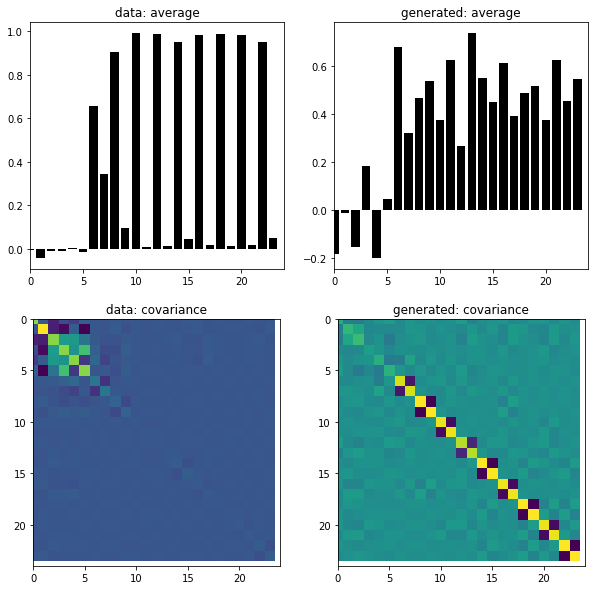

ValueError: ignored

In [73]:
generate_and_save_images(model, random_vector_for_generation,train_data)
for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    compute_apply_gradients(model, train_x, split_list, optimizer)
  end_time = time.time()

  if epoch % 10 == 0:
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
      loss(compute_loss(model, test_x, split_list))
    elbo = -loss.result()
    display.clear_output(wait=False)
    #print(model.d[1].w)
    print('Epoch: {}, Test set ELBO: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    elbo,
                                                    end_time - start_time))
    generate_and_save_images(model, random_vector_for_generation,train_data)

# checking original vs synthetic data distribution using PCA and t-SNE




In [0]:
num_examples_to_generate = 1000
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate,latent_dim])
gen_data = model.sample(random_vector_for_generation)

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=np.min([50,int(np.ceil(test_data.shape[1]/2.0))]))
pca.fit(test_data[:num_examples_to_generate])
X_embedded = pca.transform(test_data[:num_examples_to_generate])
gen_data = pca.transform(gen_data)

In [0]:
from sklearn.manifold import TSNE
tsne_istance = TSNE(n_components=2)
X_out = tsne_istance.fit_transform(np.concatenate([X_embedded,gen_data]))

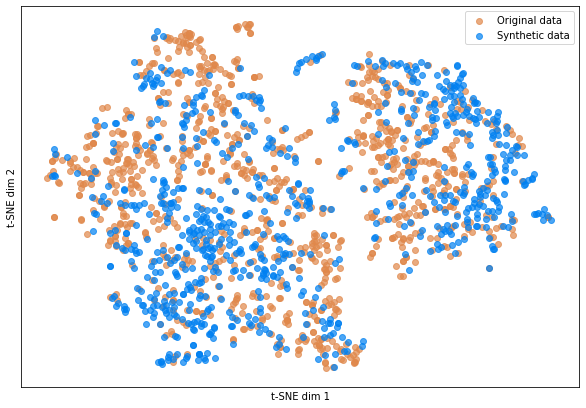

In [70]:
plt.figure(figsize=[10,7])
plt.scatter(X_out[:num_examples_to_generate,0],X_out[:num_examples_to_generate,1],c='#E0884B',label='Original data',alpha=0.7)
plt.scatter(X_out[num_examples_to_generate:,0],X_out[num_examples_to_generate:,1],c='#0080F1',label='Synthetic data',alpha=0.7)
plt.xticks([])
plt.yticks([])
plt.xlabel('t-SNE dim 1')
plt.ylabel('t-SNE dim 2')
plt.legend()
plt.savefig('t-sne.png',dpi=300)